In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from deepmeg.convtools import compute_output_shape, conviter

In [2]:
def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    """
    Generates a Gaussian random walk for a given number of points using numpy.

    Args:
        n: the number of points in the random walk
        stepsize: the standard deviation of the Gaussian distribution used to generate the random steps (default is 1.0)

    Returns:
        A numpy array of shape (n, 2) representing the x and y coordinates of the random walk.
    """
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk.T[0]


def moving_average(data: np.ndarray, kernel_size: int = 20) -> np.ndarray:
    """
    Compute the moving average of a given data array.

    Parameters
    ----------
    data : np.ndarray
        The data array.
    kernel_size : int
        The size of the kernel.

    Returns
    -------
    np.ndarray
        The moving average of the data array.
    """
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(data, kernel, mode='same')


def gen_random_data(
    batch_size,
    n_timepoints,
    out_dim,
    ma1=20,
    ma2=5
):
    data = list()
    labels = list()

    for _ in range(batch_size):
        X = 2*np.random.random((n_timepoints,)) - 1
        # X = gaussian_random_walk(n_timepoints).T[0]
        # Y = np.zeros(out_dim)
        Y = np.zeros(out_dim)
        X = moving_average(X, ma1)
        # start = np.random.randint(0, n_timepoints//4) + 250
        # dist = np.random.randint(n_timepoints//10, n_timepoints//4)
        start = np.random.randint(0, n_timepoints//2)
        dist = np.random.randint(n_timepoints//10, n_timepoints//2)
        stop = start + dist
        X[start:stop] += moving_average(2*np.random.random((stop - start)) - 1, ma2)
        # X[start:stop] = gaussian_random_walk(stop - start, 5).T[0]
        ratio = n_timepoints/out_dim
        Y[int(start/ratio):int(stop/ratio)] = 1
        # Y[start//ratio:stop//ratio] = 0
        data.append(X)
        labels.append(Y)

    return np.array(data), np.array(labels)

def interpolate_sequence(original_sequence: np.ndarray, new_length: int) -> np.ndarray:
    """
    Interpolate a sequence of length 'n' into a sequence of length 'm' (m > n)

    Args:
        original_sequence: A numpy array of shape (n, ) representing the original sequence
        new_length: An integer, the desired length of the interpolated sequence

    Returns:
        A numpy array of shape (m, ) representing the interpolated sequence
    """
    x = np.arange(original_sequence.shape[0])
    f = original_sequence
    x_new = np.linspace(0, x.max(), new_length)
    f_new = np.interp(x_new, x, f)
    return f_new

# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [3]:
import torch.nn as nn
import torch.nn.init as init
import math
import torch

class BiConv1D(nn.Module):
    def __init__(self, out_channels, window_size, latent_dim = None, overlap=0, stride=1, padding=0, bias=True):
        super().__init__()
        self.window_size = window_size
        self.latent_dim = latent_dim if latent_dim is not None else window_size // 2
        self.overlap = overlap
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.empty(self.window_size, self.latent_dim, out_channels))

        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)

    def forward(self, X):
        # inputs shape (N_batch, width) ~ (N_batch, n_times)
        X_part1 = X[:, :-(self.window_size - self.overlap)] # shape: (batches, times)
        X_part2 = X[:, self.window_size - self.overlap:,]

        assert X_part1.shape == X_part2.shape, f'Windowed sequence is corrupted: {X_part1.shape} vs {X_part2.shape}'

        convargs = ((X_part1.shape[1], X_part1.shape[0]), self.window_size, self.padding, self.stride)
        n_windows = compute_output_shape(*convargs)[0]
        out_tensor = torch.zeros(X.shape[0], n_windows, self.weight.shape[-1]) # ~ batches x n_windows x out_channels

        # iter over neurons
        for n_neuron in range(self.weight.shape[-1]):
            for p, q, k in conviter(*convargs):
                # print(p, '|', q, '|', k)
                # p shape: n_times, ...
                # q shape: n_windows, ...
                # k shape: window_size, ...
                time_range = p[0]
                window_range = k[0]
                n_window = q[0]

                window1 = X_part1[:, time_range]
                window2 = X_part2[:, time_range]
                weight = self.weight[window_range, :, n_neuron]

                proj1 = torch.matmul(window1, weight) # (N batch x time_range) @ (window_range x latent_dim x n_neuron) = (N batch x latent_dim)
                proj2 = torch.matmul(window2, weight)
                cov = torch.mean(
                    (proj1 - torch.mean(proj1, 1, keepdim=True))*
                    (proj2 - torch.mean(proj2, 1, keepdim=True)),
                    1,
                    keepdim=True
                ) # ~ (N_batch, 1)
                # out_tensor[:, q, n_neuron] = cov + self.bias[n_neuron]
                out_tensor[:, n_window, n_neuron] = torch.squeeze(cov, -1) + self.bias[n_neuron] if self.bias is not None else cov


        return out_tensor

In [4]:
x, y = gen_random_data(1000, 500, 49, ma2=10)

In [5]:
dataset = EpochsDataset((x, y), savepath='../trash')

In [6]:
dataset.save('../data/biconv_testing_dataset.pt')

In [4]:
dataset = read_epochs_dataset('../data/biconv_testing_dataset.pt')

In [7]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

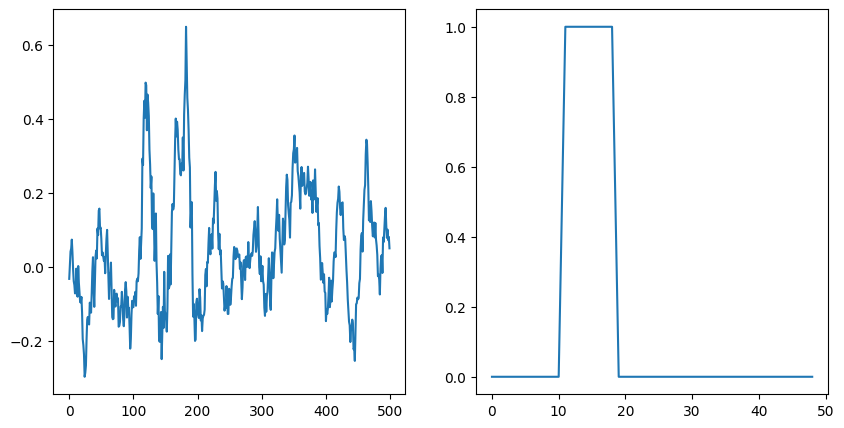

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

x, y = next(iter(DataLoader(train, batch_size=len(train))))

ax1.plot(x[3, :])
ax2.plot(y[3, :])

In [9]:
class TimeSelNet(BaseModel):

    def __init__(
        self
    ):
        super().__init__()
        self.bc = BiConv1D(
            out_channels=1,
            window_size=10,
            latent_dim=10,
            stride=10
        )
        self.bn = nn.BatchNorm1d(49)
        self.fc = nn.Linear(49, 49)
        self.activation = torch.nn.Sigmoid()


    def forward(self, x: torch.Tensor):
        x = torch.flatten(self.bc(x), 1)
        x = self.bn(x)
        x = self.fc(x)
        x = self.activation(x)
        return x

In [10]:
model = TimeSelNet()
x, y = next(iter(DataLoader(test, len(test))))
y_pred = model(x)

In [11]:
model = TimeSelNet()

optimizer = torch.optim.Adam
loss = torch.nn.L1Loss()

model.compile(
    optimizer,
    loss,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        # EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'bc.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ],
)

Epoch 0:  loss_train:  0.5191   |    loss_val:  0.5188
Epoch 1:  loss_train:  0.5171   |    loss_val:  0.5184
Epoch 2:  loss_train:  0.5150   |    loss_val:  0.5180
Epoch 3:  loss_train:  0.5128   |    loss_val:  0.5175
Epoch 4:  loss_train:  0.5104   |    loss_val:  0.5170
Epoch 5:  loss_train:  0.5078   |    loss_val:  0.5163
Epoch 6:  loss_train:  0.5051   |    loss_val:  0.5157
Epoch 7:  loss_train:  0.5022   |    loss_val:  0.5149
Epoch 8:  loss_train:  0.4991   |    loss_val:  0.5140
Epoch 9:  loss_train:  0.4959   |    loss_val:  0.5129
Epoch 10: loss_train:  0.4925   |    loss_val:  0.5117
Epoch 11: loss_train:  0.4889   |    loss_val:  0.5102
Epoch 12: loss_train:  0.4852   |    loss_val:  0.5085
Epoch 13: loss_train:  0.4814   |    loss_val:  0.5067
Epoch 14: loss_train:  0.4774   |    loss_val:  0.5047
Epoch 15: loss_train:  0.4733   |    loss_val:  0.5022
Epoch 16: loss_train:  0.4690   |    loss_val:  0.4987
Epoch 17: loss_train:  0.4646   |    loss_val:  0.4951
Epoch 18: 

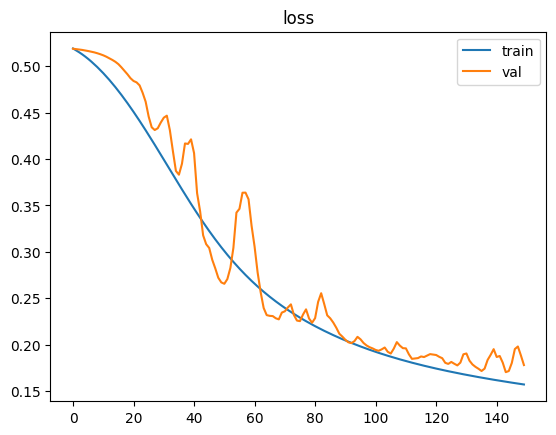

In [12]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [13]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.17069675177335739
loss: 0.17999415695667267


In [14]:
x, y = next(iter(DataLoader(test, len(test))))
y_pred = model(x)

0


Text(0.5, 0.98, 'sample 104')

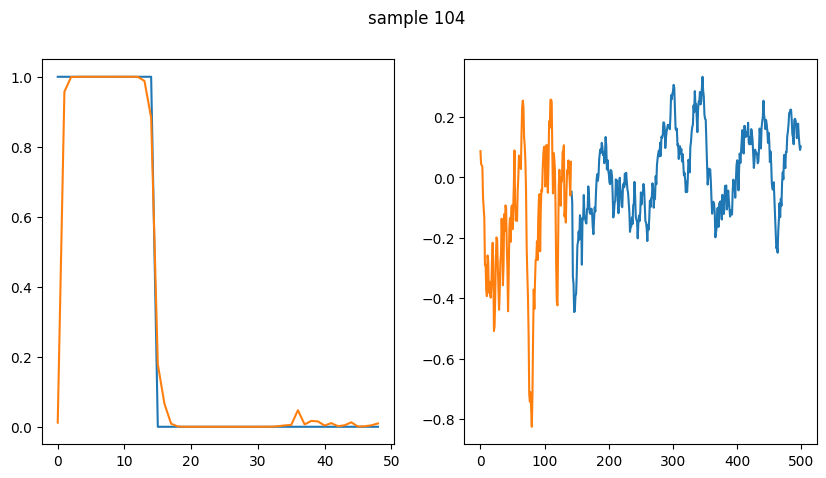

In [18]:
i = np.random.randint(300)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

pred = y_pred.detach()[i]
sample_true = x[i].numpy()
true = np.where(y[i] == 1)[0]

sample_false = sample_true.copy()
sample_false[int(true[0]*len(sample_true)/len(pred)): int(true[-1]*len(sample_true)/len(pred))] = np.nan
sample_true[:int(true[0]*len(sample_true)/len(pred))] = np.nan
sample_true[int(true[-1]*len(sample_true)/len(pred)):] = np.nan


print(int(true[0]*len(x[i])/len(pred)))

ax1.plot(y[i])
ax1.plot((pred - pred.min())/(pred.max() - pred.min()))
ax2.plot(sample_false)
ax2.plot(sample_true)
fig.suptitle(f'sample {i}')
